# Imports

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from src.data.loader import load_prices, compute_returns, ajustar_risk_free
from outputs.charts.markowitz_plot import plot_time_serie, plot_efficient_frontier
from src.optimization.markowitz import minimize_volatility
from src.optimization.sharpe import maximize_sharpe
from src.optimization.markowitz import minimize_volatility, portfolio_return, portfolio_volatility

import matplotlib.pyplot as plt
import pandas as pd

# User input

In [2]:
#tickers = ["PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA", "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "MGLU3.SA", "GGBR4.SA"] # PETR4, VALE3, ITUB4, BBDC4, BBAS3, ABEV3, WEGE3, B3SA3, MGLU3, GGBR4
tickers = ["PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA", "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "GGBR4.SA"]
start_date = "2017-01-01"
end_date = "2023-01-01"

# Frequência desejada: 'daily', 'weekly', 'monthly', 'annual'
frequencia_retorno = 'monthly'
target_return = 0.01
risk_free_rate = 0.15

# Levantando estatística dos dados

In [3]:
prices = load_prices(tickers, start=start_date, end=end_date)

returns = compute_returns(prices, freq=frequencia_retorno)

mean_returns = returns.mean()
cov_matrix = returns.cov()


/workspaces/deep_learning_finance/src/data/loader.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  9 of 9 completed
/workspaces/deep_learning_finance/src/data/loader.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = prices.resample(freq_map[freq]).last()


In [4]:
type(mean_returns)

pandas.core.series.Series

In [5]:
#print(returns)
print("\n--------------------\n")
print(mean_returns)


--------------------

Ticker
ABEV3.SA    0.003395
B3SA3.SA    0.018373
BBAS3.SA    0.012911
BBDC4.SA    0.006446
GGBR4.SA    0.023715
ITUB4.SA    0.008521
PETR4.SA    0.024955
VALE3.SA    0.023967
WEGE3.SA    0.031909
dtype: float64


In [6]:
cov_matrix # to estranhando os valores...

Ticker,ABEV3.SA,B3SA3.SA,BBAS3.SA,BBDC4.SA,GGBR4.SA,ITUB4.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Ticker,,,,,,,,,
ABEV3.SA,0.005934,0.003231,0.003292,0.003749,0.003421,0.003226,0.004018,0.001805,0.001811
B3SA3.SA,0.003231,0.009650,0.005813,0.006646,0.003311,0.006315,0.006013,0.000993,0.003876
BBAS3.SA,0.003292,0.005813,0.012472,0.008907,0.004605,0.007589,0.010525,0.000808,0.000360
BBDC4.SA,0.003749,0.006646,0.008907,0.009873,0.004731,0.008226,0.008162,0.001577,0.001797
GGBR4.SA,0.003421,0.003311,0.004605,0.004731,0.013331,0.004148,0.005793,0.005923,0.004277
ITUB4.SA,0.003226,0.006315,0.007589,0.008226,0.004148,0.008418,0.007142,0.001829,0.002208
PETR4.SA,0.004018,0.006013,0.010525,0.008162,0.005793,0.007142,0.014125,0.002205,0.001251
VALE3.SA,0.001805,0.000993,0.000808,0.001577,0.005923,0.001829,0.002205,0.007953,0.000376
WEGE3.SA,0.001811,0.003876,0.000360,0.001797,0.004277,0.002208,0.001251,0.000376,0.009236


In [7]:
weights_markowitz = minimize_volatility(mean_returns, cov_matrix, target_return)




In [8]:
risk_free_rate_annual = 0.15
risk_free_rate_daily = (1 + risk_free_rate_annual) ** (1/252) - 1

weights_sharpe = maximize_sharpe(mean_returns, cov_matrix, risk_free_rate=risk_free_rate_daily)

In [9]:
df_pesos = pd.DataFrame({
    "Ticker": tickers,
    "Peso Markowitz": weights_markowitz,
    "Peso Sharpe": weights_sharpe
})
print(df_pesos.sort_values("Peso Sharpe", ascending=False).round(4))


     Ticker  Peso Markowitz  Peso Sharpe
8  GGBR4.SA          0.2679       0.4696
7  B3SA3.SA          0.3036       0.3722
6  WEGE3.SA          0.0000       0.1583
4  BBAS3.SA          0.0000       0.0000
3  BBDC4.SA          0.0000       0.0000
5  ABEV3.SA          0.0000       0.0000
1  VALE3.SA          0.0054       0.0000
0  PETR4.SA          0.2733       0.0000
2  ITUB4.SA          0.1498       0.0000


### Chart plot - Markowitz

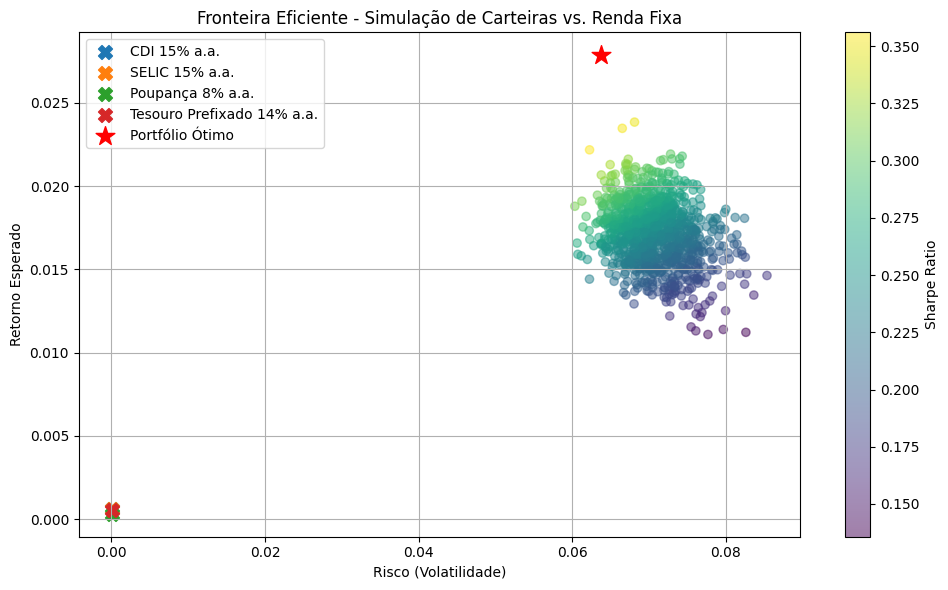

In [10]:
plot_efficient_frontier(mean_returns, cov_matrix, optimized_weights=weights_sharpe) # esse mean_returns tem que ser (pd.Series)

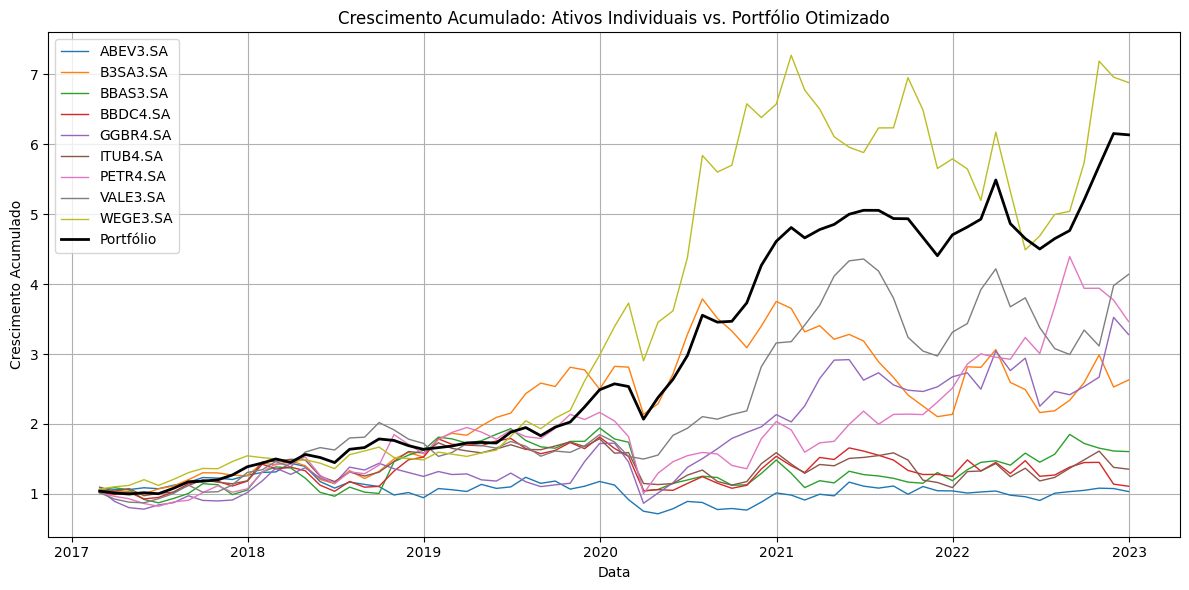

In [11]:
plot_time_serie(returns, optimized_weights=weights_sharpe) # esse mean_returns tem que ser pd.DataFrame

In [12]:
import numpy as np

# sharpe ratio individual com 100% de investimento em um ativo
sharpe_individual = (mean_returns - risk_free_rate_daily) / np.sqrt(np.diag(cov_matrix))
print(sharpe_individual.sort_values(ascending=False))


Ticker
WEGE3.SA    0.326261
VALE3.SA    0.262533
PETR4.SA    0.205304
GGBR4.SA    0.200594
B3SA3.SA    0.181378
BBAS3.SA    0.110646
ITUB4.SA    0.086821
BBDC4.SA    0.059286
ABEV3.SA    0.036867
dtype: float64


In [13]:
ret_sharpe = portfolio_return(weights_sharpe, mean_returns)
vol_sharpe = portfolio_volatility(weights_sharpe, cov_matrix)
sharpe_ratio = (ret_sharpe - risk_free_rate_daily) / vol_sharpe

print("Retorno:", ret_sharpe * 252)  # anualizado
print("Volatilidade:", vol_sharpe * 252)
print("Sharpe Ratio:", sharpe_ratio * 252)


Retorno: 7.01896298244035
Volatilidade: 16.07423410891436
Sharpe Ratio: 107.84643808496986


<Axes: title={'center': 'Portfólio vs Ativos vs CDB'}, xlabel='Date'>

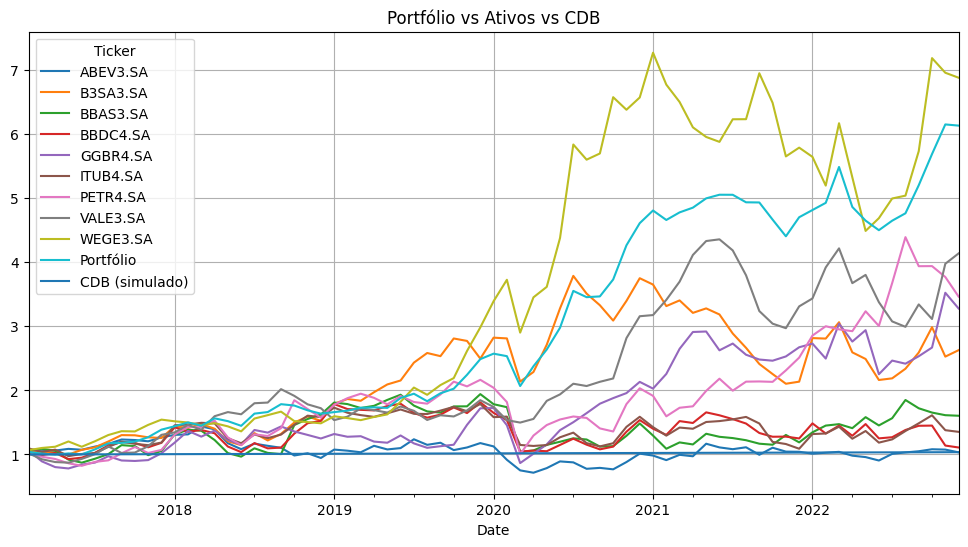

In [14]:
cdi_annual = 0.1365
cdi_daily = (1 + cdi_annual) ** (1/252) - 1

dias = len(returns)
cdb_growth = (1 + cdi_daily) ** np.arange(dias)

returns_acumulados = (1 + returns).cumprod()
returns_acumulados["Portfólio"] = (1 + returns.dot(weights_sharpe)).cumprod()
returns_acumulados["CDB (simulado)"] = cdb_growth

returns_acumulados.plot(figsize=(12, 6), title="Portfólio vs Ativos vs CDB", grid=True)


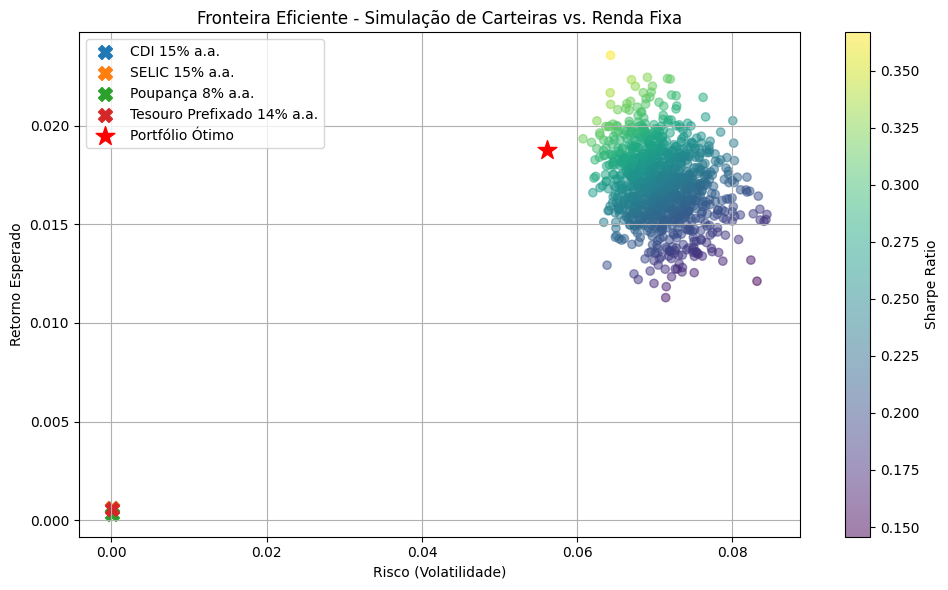

In [15]:

plot_efficient_frontier(mean_returns, cov_matrix, optimized_weights=weights_markowitz) # esse mean_returns tem que ser (pd.Series)


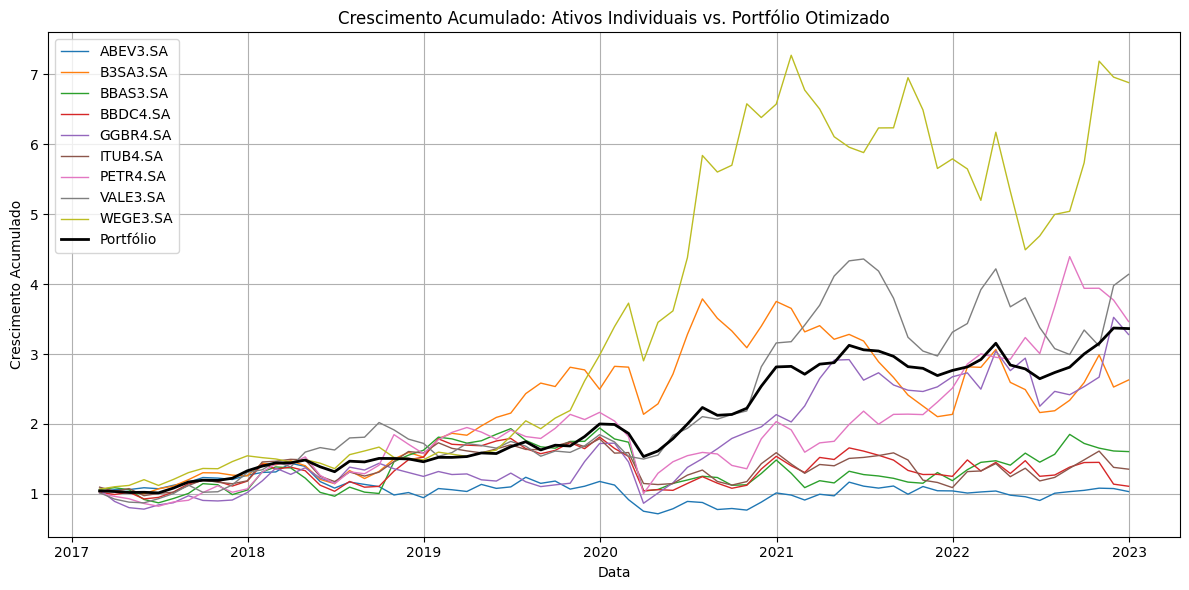

In [16]:
plot_time_serie(returns, optimized_weights=weights_markowitz) # esse mean_returns tem que ser pd.DataFrame

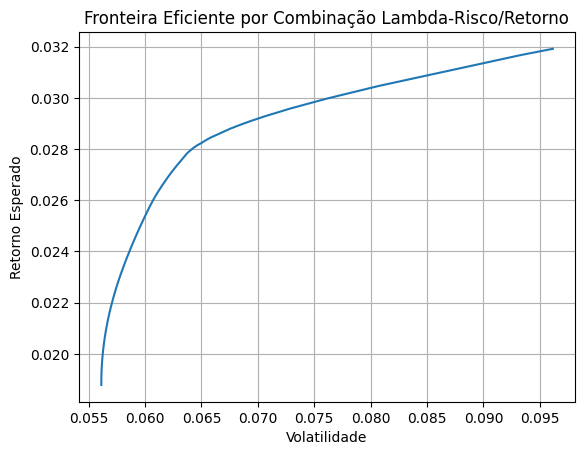

In [17]:
from outputs.charts.markowitz_plot import plot_lambda_markowitz 

plot_lambda_markowitz(mean_returns, cov_matrix)